# Single Shot Mutibox Detector (SSD)


---


物体検出タスクで主流となっているSSDについて説明します．

## 概要
SSDは，物体候補領域の検出とクラス分類を単一のネットワークで行うモデルです．SSDのネットワーク構造は，複数の畳み込み層から物体矩形と物体クラスのスコアを出力させることで，スケール変化に頑健な物体検出ができます．6つの予測レイヤでは，アスペクト比が固定されたデフォルトボックスと呼ばれる矩形を使って複数の物体候補領域を検出します．複数のアスペクト比のデフォルトボックスを使うことで，様々な形状の物体に対応可能です．予測レイヤで得られるボックスのオフセットを表す特徴マップ(Localization maps)を用いて，すべてのデフォルトボックスをより物体に近い形状に回帰します．また，同様に予測レイヤで得られる物体のクラス尤度を表す特徴マップ(Confidence maps)を用いて，物体のクラスを識別します．


<img src="https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/2654719/52d5bb7b-a6c8-9c0a-77e0-3b0b431a0a90.png" width = 100%>

<img src="https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/2654719/d16141e2-2994-d6c8-672b-bb196d187997.png" width = 40%>


### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**

# データセットの用意
まず，学習を行うデータセットをダウンロードします．ここでは，物体検出タスクの性能評価に用いられるARC2017 RGB-Dデータセットを使用します．ARC2017 RGB-Dデータセットは2017年にAmazon Robotics Challengeにて使用された全40クラスを収録する物体検出のデータセットです．
ARC2017 RGB-Dデータセットの詳細については以下サイトを参照してください．
http://mprg.jp/research/arc_dataset_2017_j

In [23]:
# データのダウンロード
!wget http://www.mprg.cs.chubu.ac.jp/MPRG_Seminar2020/ARCdataset_png.zip
!unzip -q ARCdataset_png.zip 

--2023-04-11 07:29:32--  http://www.mprg.cs.chubu.ac.jp/MPRG_Seminar2020/ARCdataset_png.zip
Resolving www.mprg.cs.chubu.ac.jp (www.mprg.cs.chubu.ac.jp)... 157.110.42.95
Connecting to www.mprg.cs.chubu.ac.jp (www.mprg.cs.chubu.ac.jp)|157.110.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274893293 (262M) [application/zip]
Saving to: ‘ARCdataset_png.zip’

ARCdataset_png.zip  100%[===================>] 262.16M  12.0MB/s    in 23s     

2023-04-11 07:29:55 (11.4 MB/s) - ‘ARCdataset_png.zip’ saved [274893293/274893293]



今回は，画像サイズは半分，枚数を削減したオリジナルのデータセットを使用します．\
40のオブジェクトと背景の全41クラスがラベル付けされています．

<img src="https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/2654719/6d9c3bc1-01d9-d433-a7fe-1b1df9aff2ce.png" width = 70%>

データセットの内容は以下のようになっています．\
データ構成: RGBの画像(640x480, .png)とバウンディングボックスデータ(.txt)\
学習データ -> 200枚 \
評価データ -> 50枚

<img src="https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/2654719/578e14bd-5514-3085-c5bb-376fd897d8d0.png" width = 50%><img src="https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/2654719/19783182-a96f-c165-4f10-4d6d36dc1e2c.png" width = 50%>

ダウンロードしたデータの中身を確認します．
フォルダARCdataset_pngには以下のフォルダ・ファイルが内包されています． \\
- train ← 学習用データ
- test ← 評価用データ
- SSD_pretrained.pth ← 学習済みモデル \\

作業ディレクトリを先程ダウンロードしたフォルダに移動します．

In [24]:
# 作業ディレクトリの移動
%cd ARCdataset_png
!ls

/content/ARCdataset_png/ARCdataset_png
SSD_pretrained.pth  train  val


In [25]:
!pwd

/content/ARCdataset_png/ARCdataset_png


## モジュールのインポート
プログラムを実行するために必要なモジュールをインポートします．
本実験では，facebookが開発した機械学習ライブラリのPyTorchを使用します．

In [26]:
import datetime
from glob import glob
import os
import sys
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import math
import random
import cv2 as cv
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchsummary

実験はGPUを使用するので，colaboratory上で使用可能な状態か確認します．

In [27]:
# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


シード値の固定を行います．

In [28]:
seed = 123

# Python random
random.seed(seed)
# Numpy
np.random.seed(seed)
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

最初に，評価する画像が入ったフォルダやネットワークのハイパーパラメータを定義します．後に作成するネットワーク定義やテストプログラムからも，値を参照できるようにしておきます．

In [29]:
class common:
  def __init__(self):
    # 学習画像のディレクトリ
    self.images_dir = "."

    # Data Augmentationにより作成されたデータのリストパス
    self.augmented_img_list = "./train/augimg_name_list.txt"

    # SSDの入力画像サイズ
    self.insize = 300                                                                 # 300×300？　これ以外だとどうなる？

    # 識別のクラス数 (背景込み)
    self.num_of_classes = 41

    # Bounding boxのオフセットベクトルの次元数                                        # オフセットとはバウンティボックスとデフォルトボックスの差分
    self.num_of_offset_dims = 4                                                       # 4次元の内二つは xとy、残り二つは？

    # Bounding boxのオフセットとクラスを推定する畳み込み層
    self.mbox_source_layers = ['conv4_3', 'conv7', 'conv8_2', 'conv9_2', 'conv10_2', 'conv11_2']

    # Default boxの最小・最大比率 (in percent %)
    self.min_ratio = 20
    self.max_ratio = 90

    # 各階層における特徴マップの入力画像上のステップ幅
    self.steps = [8, 16, 32, 64, 100, 300]

    # 各階層のdefault boxの数
    self.num_boxes = [4, 6, 6, 6, 4, 4]

    # 各階層の特徴マップのDefault boxのアスペクト比
    self.aspect_ratios = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]

    # 各階層の特徴マップの解像度
    self.map_sizes = [38, 19, 10, 5, 3, 1]

    self.loc_var = 0.01

    # Data Augmentationで増加させる倍数
    self.augmentation_factor = 2

    # Data Augmentationのパラメータ
    self.jitter = 0.3      # Default : 0.2
    self.saturation = 1.5  # Default : 1.5
    self.exposure = 1.5    # Default : 1.5
    self.hue = 0.03        # Default : 0.03

    # choose border type
    # BORDER_REPLICATE, BORDER_REFLECT, BORDER_REFLECT_101, BORDER_WRAP, BORDER_CONSTANT
    self.border_type = cv.BORDER_CONSTANT

    self.border_val = (127, 127, 127)

    # ARCクラスラベル (クラス名にはスペース(空白)は禁止)
    self.arc_labels = [
          "Background",             #0
          "Binder",                 #1
          "Balloons",               #2
          "Baby_Wipes",             #3
          "Toilet_Brush",           #4
          "Toothbrushes",           #5
          "Crayons",                #6
          "Salts",                  #7
          "DVD",                    #8
          "Glue_Sticks",            #9
          "Eraser",                 #10
          "Scissors",               #11
          "Green_Book",             #12
          "Socks",                  #13
          "Irish_Spring",           #14
          "Paper_Tape",             #15
          "Touch_Tissues",          #16
          "Knit_Gloves",            #17
          "Laugh_Out_Loud_Jokes",   #18
          "Pencil_Cup",             #19
          "Mini_Marbles",           #20
          "Neoprene_Weight",        #21
          "Wine_Glasses",           #22
          "Water_Bottle",           #23
          "Reynolds_Pie",           #24
          "Reynolds_Wrap",          #25
          "Robots_Everywhere",      #26
          "Duct_Tape",              #27
          "Sponges",                #28
          "Speed_Stick",            #29
          "Index_Cards",            #30
          "Ice_Cube_Tray",          #31
          "Table_Cover",            #32
          "Measuring_Spoons",       #33
          "Bath_Sponge",            #34
          "Pencils",                #35
          "Mousetraps",             #36
          "Face_Cloth",             #37
          "Tennis_Balls",           #38
          "Spray_Bottle",           #39
          "Flashlights"]            #40

    # アイテムIDリスト
    self.itemIDList = [
                  "0 BG",
                  "1",
                  "2",
                  "3",
                  "4",
                  "5",
                  "6",
                  "7",
                  "8",
                  "9",
                  "10",
                  "11",
                  "12",
                  "13",
                  "14",
                  "15",
                  "16",
                  "17",
                  "18",
                  "19",
                  "20",
                  "21",
                  "22",
                  "23",
                  "24",
                  "25",
                  "26",
                  "27",
                  "28",
                  "29",
                  "30",
                  "31",
                  "32",
                  "33",
                  "34",
                  "35",
                  "36",
                  "37",
                  "38",
                  "39",
                  "40",
                  "41"]

    # クラスの色
    self.arc_class_color = np.array([
               [  0,   0,   0],
               [ 85,   0,   0],
               [170,   0,   0],
               [255,   0,   0],
               [  0,  85,   0],
               [ 85,  85,   0],
               [170,  85,   0],
               [255,  85,   0],
               [  0, 170,   0],
               [ 85, 170,   0],
               [170, 170,   0],
               [255, 170,   0],
               [  0, 255,   0],
               [ 85, 255,   0],
               [170, 255,   0],
               [255, 255,   0],
               [  0,   0,  85],
               [ 85,   0,  85],
               [170,   0,  85],
               [255,   0,  85],
               [  0,  85,  85],
               [ 85,  85,  85],
               [170,  85,  85],
               [255,  85,  85],
               [  0, 170,  85],
               [ 85, 170,  85],
               [170, 170,  85],
               [255, 170,  85],
               [  0, 255,  85],
               [ 85, 255,  85],
               [170, 255,  85],
               [255, 255,  85],
               [  0,   0, 170],
               [ 85,   0, 170],
               [170,   0, 170],
               [255,   0, 170],
               [  0,  85, 170],
               [ 85,  85, 170],
               [170,  85, 170],
               [255,  85, 170],
               [  0, 170, 170]])

common_params = common()

## データ拡張
Data Augmentationの処理を記述します．trainフォルダ内にデータ拡張済みのBoundingBoxファイルが用意されており，データ拡張済みのファイルが読み込まれた際に画像に対してData Augmentation処理が実行されます．\
読み込まれたRGB画像は一度HSV形式に変換され，歪みを加えたRGB画像を新たに生成します．

In [30]:
# BGR -> HSV
def BGR_2_HSV_(img):

    h = np.zeros((img.shape[0], img.shape[1]), np.float32)
    s = np.zeros((img.shape[0], img.shape[1]), np.float32)
    v = np.zeros((img.shape[0], img.shape[1]), np.float32)

    img_r = img.copy()
    b = img[:, :, 0]                              # ここから3行は何をしている？　rgbの色に関係? -> https://qiita.com/kikuchiTakuya/items/298d83efd82dedd4adda
    g = img[:, :, 1]
    r = img[:, :, 2]
    max_v = cv.max(cv.max(b, g), r)
    min_v = cv.min(cv.min(b, g), r)
    delta = max_v - min_v
    v = max_v
    zero_m = (max_v == 0.)
    zero_m = zero_m.astype(np.float32)
    nonzeor_m = (max_v != 0.)
    nonzeor_m = nonzeor_m.astype(np.float32)

    exp_m = zero_m * 10e-8

    s = delta / (max_v + exp_m)
    s = s * nonzeor_m

    rmax = (r == max_v)
    rmax = rmax.astype(np.float32)

    gmax = (g == max_v)
    gr = (g != r)
    gmax = gmax.astype(np.float32)
    gr = gr.astype(np.float32)
    gmax = gmax * gr

    bmax = (b == max_v)
    br = (b != r)
    bg = (b != g)
    bmax = bmax.astype(np.float32)
    br = br.astype(np.float32)
    bg = bg.astype(np.float32)
    bmax = bmax * br * bg

    h += ((g - b) / (delta + 10e-8)) * rmax
    h += (((b - r) / (delta + 10e-8)) + 2.) * gmax
    h += (((r - g) / (delta + 10e-8)) + 4.) * bmax

    h = h * (np.pi / 3.)

    neg_m = (h < 0.0)
    neg_m = neg_m.astype(np.float32)
    h += neg_m * (2. * np.pi)

    h = h / (2. * np.pi)

    img_r[:, :, 0] = h
    img_r[:, :, 1] = s
    img_r[:, :, 2] = v

    return img_r

# HSV -> BGR
def HSV_2_BGR_(img):

    r = np.zeros((img.shape[0], img.shape[1]), np.float32)
    g = np.zeros((img.shape[0], img.shape[1]), np.float32)
    b = np.zeros((img.shape[0], img.shape[1]), np.float32)

    img_r = img.copy()
    h = img[:, :, 0]
    s = img[:, :, 1]
    v = img[:, :, 2]

    h = h * (2. * np.pi)

    zero_m = (s == 0.)
    zero_m = zero_m.astype(np.float32)
    nonzeor_m = (s != 0.)
    nonzeor_m = nonzeor_m.astype(np.float32)

    idx = np.floor(h)
    idx = idx.astype(np.int16)

    f = h - idx
    p = v * (1. - s)
    q = v * (1. - s * ((3. / np.pi) * f))
    t = v * (1. - s * (1. - ((3. / np.pi) * f)))

    idx0 = (idx == 0)
    idx0 = idx0.astype(np.float32)

    idx1 = (idx == 1)
    idx1 = idx1.astype(np.float32)

    idx2 = (idx == 2)
    idx2 = idx2.astype(np.float32)

    idx3 = (idx == 3)
    idx3 = idx3.astype(np.float32)

    idx4 = (idx == 4)
    idx4 = idx4.astype(np.float32)

    idxE = idx0 + idx1 + idx2 + idx3 + idx4
    idxE = (idxE == 0)
    idxE = idxE.astype(np.float32)

    r += v * idx0
    g += t * idx0
    b += p * idx0

    r += q * idx1
    g += v * idx1
    b += p * idx1

    r += p * idx2
    g += v * idx2
    b += t * idx2

    r += p * idx3
    g += q * idx3
    b += v * idx3

    r += t * idx4
    g += p * idx4
    b += v * idx4

    r += v * idxE
    g += p * idxE
    b += q * idxE

    r = r * nonzeor_m
    g = g * nonzeor_m
    b = b * nonzeor_m

    r += v * zero_m
    g += v * zero_m
    b += v * zero_m

    img_r[:, :, 0] = b
    img_r[:, :, 1] = g
    img_r[:, :, 2] = r

    return img_r

# 歪みをくわえた画像を生成
def distortImage(img, dhue, dsat, dexp):

    img = BGR_2_HSV_(img)

    n = img.shape[0] * img.shape[1]

    img[:, :, 0] = img[:, :, 0] + dhue
    img[:, :, 1] = img[:, :, 1] * dsat
    img[:, :, 2] = img[:, :, 2] * dexp

    m = img[:, :, 0] > 1.
    m = m.astype(np.float32)
    p = img[:, :, 0] < 0.
    p = p.astype(np.float32)

    img[:, :, 0] = img[:, :, 0] - m
    img[:, :, 0] = img[:, :, 0] + p

    img = HSV_2_BGR_(img)

    img = np.minimum(np.maximum(img, 0.), 1.)

    return img


# Data augmentation 処理
def trainAugmentation(img, border_pixels, crop_param, hsv_param, flip_type):

    hsv_srand = 0

    if hsv_srand == 1:
        dhue = hsv_param[0]
        dsat = hsv_param[1]
        dexp = hsv_param[2]
    else:
        dhue = random.uniform(-1. * common_params.hue, common_params.hue)
        dsat = random.uniform(1., common_params.saturation)
        dexp = random.uniform(1., common_params.exposure)
        if random.randint(0, 1) == 0:
            dsat = 1. / dsat
        if random.randint(0, 1) == 0:
            dexp = 1. / dexp

    if random.randint(0, 4) >= 1:
        img = img.astype(np.float32)
        img /= 255.
        img = distortImage(img, dhue, dsat, dexp)
        img *= 255.
        img = img.astype(np.uint8)

    if common_params.border_type == cv.BORDER_CONSTANT:
        cropped_img = cv.copyMakeBorder(img, border_pixels[1], border_pixels[3], border_pixels[0], border_pixels[2], common_params.border_type, value = common_params.border_val)
    else:
        cropped_img = cv.copyMakeBorder(img, border_pixels[1], border_pixels[3], border_pixels[0], border_pixels[2], common_params.border_type)

    cropped_img = cv.getRectSubPix(cropped_img, (int(crop_param[2]), int(crop_param[3])), (crop_param[0], crop_param[1]))
    cropped_img = cv.resize(cropped_img, (common_params.insize, common_params.insize), interpolation = cv.INTER_CUBIC)

    if flip_type >= 0:
        cropped_img = cv.flip(cropped_img, flip_type)

    return cropped_img

## データローダの作成
データセットの読み込み方を定義したデータローダを作成します．
オリジナルのデータセットを使用する場合に必要です．\
今回は`transforms.Compose`のデータ拡張機能は使用せずに，MYDatasetクラスを`DataLoader`に与えてデータを読み込みます． \
バッチサイズは5，データセット読み込みに割り当てるスレッド数(num_workers)は2とします．

In [31]:
# バッチサイズの設定
batch_size = 5

class MYDataset(Dataset):
    def __init__(self, input_list_path, confing_image):
        f = open(input_list_path, 'r')
        input_list = []
        for line in f:
            ln = line.split('\n')
            input_list.append(ln[0])
        input_list.sort()
        f.close()

        self.input_list = np.array(input_list)
        self.confing_image = confing_image
        print("Training images : ", len(self.input_list))

    def __len__(self):
        return len(self.input_list)

    def __getitem__(self, i):
        input_name = self.input_list[i]

        # Detection teach
        aug_p = open(common_params.images_dir + "/train/img_aug_param/" + input_name + ".txt", 'r')

        in_line = aug_p.readline()  #aug_pを1行ずつ読み込み
        opath = in_line.split(' \n')    #改行で区切る
        original_img_path = str(opath[0])

        in_line = aug_p.readline()
        augmentation = int(in_line)

        in_line = aug_p.readline()
        part = in_line.split(' ')
        border_pixels = [int(part[0]), int(part[1]), int(part[2]), int(part[3])]

        in_line = aug_p.readline()
        part = in_line.split(' ')
        crop_param = [float(part[0]), float(part[1]), float(part[2]), float(part[3])]

        in_line = aug_p.readline()
        part = in_line.split(' ')
        hsv_param = [float(part[0]), float(part[1]), float(part[2])]

        in_line = aug_p.readline()
        flip_type = int(in_line)

        # Input image
        color_img = cv.imread(common_params.images_dir + "/train/rgb/" + original_img_path + ".png", cv.IMREAD_COLOR)

        # 画像をSSDの入力サイズにリサイズ
        input_img = cv.resize(color_img, (common_params.insize, common_params.insize), interpolation = cv.INTER_CUBIC)  #バイキュビック補間

        # Data Augmentationにより作成されたBoundingBox情報か判定
        if augmentation == 1:
            input_img = trainAugmentation(input_img, border_pixels, crop_param, hsv_param, flip_type)   #data augmentation

        if self.confing_image:
            conf_img = input_img.copy()

        # 画像データをfloatに変換
        input_img = input_img.astype(np.float32)

        # 画像の平均値を引く
        input_img -= np.array([103.939, 116.779, 123.68])

        # 画像の次元を(高さ，幅，チャンネル数)から(チャンネル数, 高さ，幅)へ転置
        input_img = input_img.transpose(2, 0, 1)

        gt_boxes = []
        df_boxes = []
        indices = []
        classes = []
        idx_tmp = []

        # positiveサンプルの読み込み
        pos_num = 0
        f = open(common_params.images_dir + "/train/positives/" + input_name + ".txt", 'r')
        for rw in f:
            ln = rw.split(' ')
            classes.append(int(ln[1]))
            gt_boxes.append([float(ln[2]), float(ln[3]), float(ln[4]), float(ln[5])])
            df_boxes.append([float(ln[6]), float(ln[7]), float(ln[8]), float(ln[9])])
            indices.append([int(ln[10]), int(ln[11]), int(ln[12]), int(ln[13])])
            pos_num += 1
        f.close()

        # hard negativeサンプルの読み込み (最大でpositiveサンプル数の3倍)
        neg_num = 0
        f = open(common_params.images_dir + "/train/negatives/" + input_name + ".txt", 'r')
        for rw in f:
            ln = rw.split(' ')
            classes.append(int(ln[1]))
            gt_boxes.append([float(ln[2]), float(ln[3]), float(ln[4]), float(ln[5])])
            df_boxes.append([float(ln[2]), float(ln[3]), float(ln[4]), float(ln[5])])
            idx_tmp.append([int(ln[10]), int(ln[11]), int(ln[12]), int(ln[13])])
            neg_num += 1
        f.close()

        hardneg_size = pos_num * 3 if neg_num > (pos_num * 3) else neg_num

        perm = np.random.permutation(len(idx_tmp))

        for hn in range(0, hardneg_size):
            indices.append(idx_tmp[perm[hn]])

        # padding処理 ???(random) -> 8732(dfbox max size)
        max_boxes = 8732 * 4

        if len(gt_boxes) == 0:
            gt_boxes = np.ones((max_boxes, 4)) * -100
        elif len(gt_boxes) != max_boxes:
            gt_boxes = np.pad(np.array(gt_boxes), [(0,max_boxes-len(gt_boxes)), (0,0)], 'constant', constant_values=-100)

        if len(df_boxes) == 0:
            df_boxes = np.ones((max_boxes, 4)) * -100
        elif len(df_boxes) != max_boxes:
            df_boxes = np.pad(np.array(df_boxes), [(0,max_boxes-len(df_boxes)), (0,0)], 'constant', constant_values=-100)

        if len(indices) == 0:
            indices = np.ones((max_boxes, 4)) * -100
        elif len(indices) != max_boxes:
            indices = np.pad(np.array(indices), [(0,max_boxes-len(indices)), (0,0)], 'constant', constant_values=-100)

        if len(classes) == 0:
            classes = np.ones((max_boxes,)) * -100
        elif len(classes) != max_boxes:
            classes = np.pad(np.array(classes), (0,max_boxes-len(classes)), 'constant', constant_values=-100)

        # list to tensor
        input_img = torch.tensor(input_img, dtype=torch.float32).cpu()
        gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32).cpu()
        df_boxes = torch.tensor(df_boxes, dtype=torch.float32).cpu()
        indices = torch.tensor(indices, dtype=torch.int64).cpu()
        classes = torch.tensor(classes, dtype=torch.int64).cpu()
        conf_img = torch.tensor(conf_img).cpu()

        return input_img, gt_boxes, df_boxes, indices, classes, conf_img

# Dataset import
train_dataset = MYDataset(common_params.augmented_img_list, True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Training images :  400


# ネットワークモデルの定義
次に，SSDのネットワークを定義します．SSDは入力サイズが300x300のSSD300と512x512のSSD512があります．SSD512の方が入力サイズが大きいため，基本的には検出精度は向上しますが処理に時間がかかります．今回の実験では，入力サイズの小さいSSD300を用います．\
SSDはVGGをベースとしており，ネットワークの前段で小さい物体の特徴を捉え，後段で大きい物体の特徴を捉えます．\
SSD300では畳み込み層の(`Conv4_3,`,`Conv7`,`Conv8_2`,`Conv9_2`,`Conv10_2`,`Conv11_2`)からBounding boxのオフセットとクラスを推定します．
また，`Conv4_3`の時のみL2正規化後(`L2Normalization`)の出力値を推定する層に用います．これは入力層に近い層のスケールが大きくなるのを防ぐためです．

In [32]:
class L2Normalization(nn.Module):  # L2正規化
    def __init__(self, channels, gamma=20):
        super().__init__()
        self.gamma = gamma
        self.in_channels = channels
        self.out_channels = channels
        self.scales = nn.Parameter(torch.Tensor(self.in_channels))  # trainable
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.constant_(self.scales, self.gamma)  # initialized with gamma first

    # Note that pytorch's dimension order is batch_size, channels, height, width
    def forward(self, x):
        # |x|_2
        # normalize (x^)
        x = F.normalize(x, p=2, dim=1)
        return self.scales.unsqueeze(0).unsqueeze(2).unsqueeze(3) * x


class SSDNet(nn.Module):  # SSDのネットワーク構築

    def __init__(self):
        super(SSDNet, self).__init__()
        # feature layers
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.relu1_2 = nn.ReLU(inplace=True)

        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.relu2_2 = nn.ReLU(inplace=True)

        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.relu3_3 = nn.ReLU(inplace=True)

        self.maxpool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, ceil_mode = True)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu4_3 = nn.ReLU(inplace=True)

        self.l2norm4_3 = L2Normalization(channels=512, gamma=20)

        self.maxpool4 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu5_3 = nn.ReLU(inplace=True)

        self.maxpool5 = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)

        self.conv6 = nn.Conv2d(512, 1024, kernel_size = 3, stride = 1, padding = 6, dilation=6)
        self.relu6 = nn.ReLU(inplace=True)
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size = 1, stride = 1, padding = 0)
        self.relu7 = nn.ReLU(inplace=True)

        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.relu8_1 = nn.ReLU(inplace=True)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.relu8_2 = nn.ReLU(inplace=True)

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, stride=1, padding=0)
        self.relu9_1 = nn.ReLU(inplace=True)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.relu9_2 = nn.ReLU(inplace=True)

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0)
        self.relu10_1 = nn.ReLU(inplace=True)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.relu10_2 = nn.ReLU(inplace=True)

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0)
        self.relu11_1 = nn.ReLU(inplace=True)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.relu11_2 = nn.ReLU(inplace=True)

        # localization layers
        self.conv4_3_loc = nn.Conv2d(512, common_params.num_of_offset_dims * common_params.num_boxes[0], kernel_size=3, stride=1, padding=1)
        self.conv7_loc = nn.Conv2d(1024, common_params.num_of_offset_dims * common_params.num_boxes[1], kernel_size=3, stride=1, padding=1)
        self.conv8_2_loc = nn.Conv2d(512, common_params.num_of_offset_dims * common_params.num_boxes[2], kernel_size=3, stride=1, padding=1)
        self.conv9_2_loc = nn.Conv2d(256, common_params.num_of_offset_dims * common_params.num_boxes[3], kernel_size=3, stride=1, padding=1)
        self.conv10_2_loc = nn.Conv2d(256, common_params.num_of_offset_dims * common_params.num_boxes[4], kernel_size=3, stride=1, padding=1)
        self.conv11_2_loc = nn.Conv2d(256, common_params.num_of_offset_dims * common_params.num_boxes[5], kernel_size=3, stride=1, padding=1)

        # confidence layers
        self.conv4_3_cls = nn.Conv2d(512, common_params.num_of_classes * common_params.num_boxes[0], kernel_size=3, stride=1, padding=1)
        self.conv7_cls = nn.Conv2d(1024, common_params.num_of_classes * common_params.num_boxes[1], kernel_size=3, stride=1, padding=1)
        self.conv8_2_cls = nn.Conv2d(512, common_params.num_of_classes * common_params.num_boxes[2], kernel_size=3, stride=1, padding=1)
        self.conv9_2_cls = nn.Conv2d(256, common_params.num_of_classes * common_params.num_boxes[3], kernel_size=3, stride=1, padding=1)
        self.conv10_2_cls = nn.Conv2d(256, common_params.num_of_classes * common_params.num_boxes[4], kernel_size=3, stride=1, padding=1)
        self.conv11_2_cls = nn.Conv2d(256, common_params.num_of_classes * common_params.num_boxes[5], kernel_size=3, stride=1, padding=1)

    def forward(self, x, train=False):

        k1 = self.relu1_1(self.conv1_1(x))
        k1 = self.relu1_2(self.conv1_2(k1))

        k1 = self.maxpool1(k1)

        k1 = self.relu2_1(self.conv2_1(k1))
        k1 = self.relu2_2(self.conv2_2(k1))

        k1 = self.maxpool2(k1)

        k1 = self.relu3_1(self.conv3_1(k1))
        k1 = self.relu3_2(self.conv3_2(k1))
        k1 = self.relu3_3(self.conv3_3(k1))

        k1 = self.maxpool3(k1)

        k1 = self.relu4_1(self.conv4_1(k1))
        k1 = self.relu4_2(self.conv4_2(k1))
        k1 = self.relu4_3(self.conv4_3(k1))

        l2_k1 = self.l2norm4_3(k1)
        Loc1 = self.conv4_3_loc(l2_k1)  # Box_Estimator_1
        Cls1 = self.conv4_3_cls(l2_k1)  # Class_Classifier_1

        k2 = self.maxpool4(k1)

        k2 = self.relu5_1(self.conv5_1(k2))
        k2 = self.relu5_2(self.conv5_2(k2))
        k2 = self.relu5_3(self.conv5_3(k2))

        k2 = self.maxpool5(k2)

        k2 = self.relu6(self.conv6(k2))
        k2 = self.relu7(self.conv7(k2))

        Loc2 = self.conv7_loc(k2)  # Box_Estimator_2
        Cls2 = self.conv7_cls(k2)  # Class_Classifier_2

        k3 = self.relu8_1(self.conv8_1(k2))
        k3 = self.relu8_2(self.conv8_2(k3))

        Loc3 = self.conv8_2_loc(k3)  # Box_Estimator_3
        Cls3 = self.conv8_2_cls(k3)  # Class_Classifier_3

        k4 = self.relu9_1(self.conv9_1(k3))
        k4 = self.relu9_2(self.conv9_2(k4))

        Loc4 = self.conv9_2_loc(k4)  # Box_Estimator_4
        Cls4 = self.conv9_2_cls(k4)  # Class_Classifier_4

        k5 = self.relu10_1(self.conv10_1(k4))
        k5 = self.relu10_2(self.conv10_2(k5))

        Loc5 = self.conv10_2_loc(k5)  # Box_Estimator_5
        Cls5 = self.conv10_2_cls(k5)  # Class_Classifier_5

        k6 = self.relu11_1(self.conv11_1(k5))
        k6 = self.relu11_2(self.conv11_2(k6))

        Loc6 = self.conv11_2_loc(k6)  # Box_Estimator_6
        Cls6 = self.conv11_2_cls(k6)  # Class_Classifier_6

        if train:
            # (バッチ数,チャンネル数,高さ,幅) -> (バッチ数,高さ,幅,チャンネル数) メモリ上で要素順に並べ直す
            Loc1 = Loc1.permute(0, 2, 3, 1).contiguous()
            Cls1 = Cls1.permute(0, 2, 3, 1).contiguous()

            Loc2 = Loc2.permute(0, 2, 3, 1).contiguous()
            Cls2 = Cls2.permute(0, 2, 3, 1).contiguous()

            Loc3 = Loc3.permute(0, 2, 3, 1).contiguous()
            Cls3 = Cls3.permute(0, 2, 3, 1).contiguous()

            Loc4 = Loc4.permute(0, 2, 3, 1).contiguous()
            Cls4 = Cls4.permute(0, 2, 3, 1).contiguous()

            Loc5 = Loc5.permute(0, 2, 3, 1).contiguous()
            Cls5 = Cls5.permute(0, 2, 3, 1).contiguous()

            Loc6 = Loc6.permute(0, 2, 3, 1).contiguous()
            Cls6 = Cls6.permute(0, 2, 3, 1).contiguous()

            Loc1 = Loc1.view(Loc1.data.shape[0] * Loc1.data.shape[1] * Loc1.data.shape[2] * common_params.num_boxes[0], int(Loc1.data.shape[3] / common_params.num_boxes[0]))
            Cls1 = Cls1.view(Cls1.data.shape[0] * Cls1.data.shape[1] * Cls1.data.shape[2] * common_params.num_boxes[0], int(Cls1.data.shape[3] / common_params.num_boxes[0]))

            Loc2 = Loc2.view(Loc2.data.shape[0] * Loc2.data.shape[1] * Loc2.data.shape[2] * common_params.num_boxes[1], int(Loc2.data.shape[3] / common_params.num_boxes[1]))
            Cls2 = Cls2.view(Cls2.data.shape[0] * Cls2.data.shape[1] * Cls2.data.shape[2] * common_params.num_boxes[1], int(Cls2.data.shape[3] / common_params.num_boxes[1]))

            Loc3 = Loc3.view(Loc3.data.shape[0] * Loc3.data.shape[1] * Loc3.data.shape[2] * common_params.num_boxes[2], int(Loc3.data.shape[3] / common_params.num_boxes[2]))
            Cls3 = Cls3.view(Cls3.data.shape[0] * Cls3.data.shape[1] * Cls3.data.shape[2] * common_params.num_boxes[2], int(Cls3.data.shape[3] / common_params.num_boxes[2]))

            Loc4 = Loc4.view(Loc4.data.shape[0] * Loc4.data.shape[1] * Loc4.data.shape[2] * common_params.num_boxes[3], int(Loc4.data.shape[3] / common_params.num_boxes[3]))
            Cls4 = Cls4.view(Cls4.data.shape[0] * Cls4.data.shape[1] * Cls4.data.shape[2] * common_params.num_boxes[3], int(Cls4.data.shape[3] / common_params.num_boxes[3]))

            Loc5 = Loc5.view(Loc5.data.shape[0] * Loc5.data.shape[1] * Loc5.data.shape[2] * common_params.num_boxes[4], int(Loc5.data.shape[3] / common_params.num_boxes[4]))
            Cls5 = Cls5.view(Cls5.data.shape[0] * Cls5.data.shape[1] * Cls5.data.shape[2] * common_params.num_boxes[4], int(Cls5.data.shape[3] / common_params.num_boxes[4]))

            Loc6 = Loc6.view(Loc6.data.shape[0] * Loc6.data.shape[1] * Loc6.data.shape[2] * common_params.num_boxes[5], int(Loc6.data.shape[3] / common_params.num_boxes[5]))
            Cls6 = Cls6.view(Cls6.data.shape[0] * Cls6.data.shape[1] * Cls6.data.shape[2] * common_params.num_boxes[5], int(Cls6.data.shape[3] / common_params.num_boxes[5]))

            return (Loc1, Cls1, Loc2, Cls2, Loc3, Cls3, Loc4, Cls4, Loc5, Cls5, Loc6, Cls6)

        else:
            return (Loc1, Cls1, Loc2, Cls2, Loc3, Cls3, Loc4, Cls4, Loc5, Cls5, Loc6, Cls6)

model = SSDNet()
if use_cuda:
  model.cuda()
# モデルの情報を表示
torchsummary.summary(model, (3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,792
              ReLU-2         [-1, 64, 300, 300]               0
            Conv2d-3         [-1, 64, 300, 300]          36,928
              ReLU-4         [-1, 64, 300, 300]               0
         MaxPool2d-5         [-1, 64, 150, 150]               0
            Conv2d-6        [-1, 128, 150, 150]          73,856
              ReLU-7        [-1, 128, 150, 150]               0
            Conv2d-8        [-1, 128, 150, 150]         147,584
              ReLU-9        [-1, 128, 150, 150]               0
        MaxPool2d-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]         295,168
             ReLU-12          [-1, 256, 75, 75]               0
           Conv2d-13          [-1, 256, 75, 75]         590,080
             ReLU-14          [-1, 256,

# 損失関数の定義
学習に使用する損失関数と最適化手法を定義します．Loss計算はGPUよりもCPUの方が高速に処理できるため，CPU上で処理を行います．\
最初に各層のクラス推定と位置推定を行う層と教師データのBounding box情報を照らし合わせるために，同等の特徴マップを用意して教示データを格納しています．
クラス推定にはクロスエントロピー誤差，位置推定にはsmooth L1誤差を用いて誤差を算出します．

In [33]:
class MYLoss(nn.Module):
    def __init__(self):
        super(MYLoss, self).__init__()

    def forward(self, Loc, Cls, gt_box_batch, df_box_batch, idx_batch, cls_batch, bat_s, mining):
        if mining:
            # hard negative mining有効時のクラスラベル
            cls_t1 = torch.ones((bat_s, common_params.num_boxes[0], common_params.map_sizes[0], common_params.map_sizes[0]), dtype = torch.int64).cpu() * -1
            cls_t2 = torch.ones((bat_s, common_params.num_boxes[1], common_params.map_sizes[1], common_params.map_sizes[1]), dtype = torch.int64).cpu() * -1
            cls_t3 = torch.ones((bat_s, common_params.num_boxes[2], common_params.map_sizes[2], common_params.map_sizes[2]), dtype = torch.int64).cpu() * -1
            cls_t4 = torch.ones((bat_s, common_params.num_boxes[3], common_params.map_sizes[3], common_params.map_sizes[3]), dtype = torch.int64).cpu() * -1
            cls_t5 = torch.ones((bat_s, common_params.num_boxes[4], common_params.map_sizes[4], common_params.map_sizes[4]), dtype = torch.int64).cpu() * -1
            cls_t6 = torch.ones((bat_s, common_params.num_boxes[5], common_params.map_sizes[5], common_params.map_sizes[5]), dtype = torch.int64).cpu() * -1
        else:
            # hard negative mining無効時のクラスラベル
            cls_t1 = torch.zeros((bat_s, common_params.num_boxes[0], common_params.map_sizes[0], common_params.map_sizes[0]), dtype = torch.int64).cpu() 
            cls_t2 = torch.zeros((bat_s, common_params.num_boxes[1], common_params.map_sizes[1], common_params.map_sizes[1]), dtype = torch.int64).cpu() 
            cls_t3 = torch.zeros((bat_s, common_params.num_boxes[2], common_params.map_sizes[2], common_params.map_sizes[2]), dtype = torch.int64).cpu() 
            cls_t4 = torch.zeros((bat_s, common_params.num_boxes[3], common_params.map_sizes[3], common_params.map_sizes[3]), dtype = torch.int64).cpu() 
            cls_t5 = torch.zeros((bat_s, common_params.num_boxes[4], common_params.map_sizes[4], common_params.map_sizes[4]), dtype = torch.int64).cpu() 
            cls_t6 = torch.zeros((bat_s, common_params.num_boxes[5], common_params.map_sizes[5], common_params.map_sizes[5]), dtype = torch.int64).cpu() 

        # bounding boxのオフセットベクトルの教示データ
        loc_t1 = torch.zeros((bat_s, common_params.num_boxes[0] * common_params.num_of_offset_dims, common_params.map_sizes[0], common_params.map_sizes[0]), dtype = torch.float32).cpu()
        loc_t2 = torch.zeros((bat_s, common_params.num_boxes[1] * common_params.num_of_offset_dims, common_params.map_sizes[1], common_params.map_sizes[1]), dtype = torch.float32).cpu()
        loc_t3 = torch.zeros((bat_s, common_params.num_boxes[2] * common_params.num_of_offset_dims, common_params.map_sizes[2], common_params.map_sizes[2]), dtype = torch.float32).cpu()
        loc_t4 = torch.zeros((bat_s, common_params.num_boxes[3] * common_params.num_of_offset_dims, common_params.map_sizes[3], common_params.map_sizes[3]), dtype = torch.float32).cpu()
        loc_t5 = torch.zeros((bat_s, common_params.num_boxes[4] * common_params.num_of_offset_dims, common_params.map_sizes[4], common_params.map_sizes[4]), dtype = torch.float32).cpu()
        loc_t6 = torch.zeros((bat_s, common_params.num_boxes[5] * common_params.num_of_offset_dims, common_params.map_sizes[5], common_params.map_sizes[5]), dtype = torch.float32).cpu()

        cls_t = ([cls_t1, cls_t2, cls_t3, cls_t4, cls_t5, cls_t5])
        loc_t = ([loc_t1, loc_t2, loc_t3, loc_t4, loc_t5, loc_t6])

        for b in range(0, len(idx_batch)):
            for i in range(0, len(idx_batch[b])):
                if int(idx_batch[b][i][1]) == -100: break
                fmap_layer = idx_batch[b][i][1]
                fmap_position = idx_batch[b][i][2]
                df_box_num = idx_batch[b][i][3]
                st_box_idx = df_box_num * common_params.num_of_offset_dims
                ed_box_idx = st_box_idx + common_params.num_of_offset_dims

                c = int(fmap_position % common_params.map_sizes[fmap_layer])
                r = int(fmap_position / common_params.map_sizes[fmap_layer])

                item_class_id = cls_batch[b][i]

                # 1〜6番目のdefault boxのクラスとオフセットの教示データを格納
                gt_box_batch_idx = gt_box_batch[b][i]
                df_box_batch_idx = df_box_batch[b][i]

                cls_t[fmap_layer][b, df_box_num, r, c] = cls_batch[b][i]
                loc_t[fmap_layer][b, st_box_idx : ed_box_idx, r, c] = (gt_box_batch_idx - df_box_batch_idx) / common_params.loc_var

        # 1〜6階層目の教示confidence mapの次元を(バッチ数, DF box数, 高さ, 幅)から(バッチ数, 高さ, 幅, DF box数)に転置
        cls_t1 = cls_t1.permute(0, 2, 3, 1).contiguous()
        cls_t2 = cls_t2.permute(0, 2, 3, 1).contiguous()
        cls_t3 = cls_t3.permute(0, 2, 3, 1).contiguous()
        cls_t4 = cls_t4.permute(0, 2, 3, 1).contiguous()
        cls_t5 = cls_t5.permute(0, 2, 3, 1).contiguous()
        cls_t6 = cls_t6.permute(0, 2, 3, 1).contiguous()

        # 1〜6階層目の教示confidence mapの各次元数を(バッチ数, 高さ, 幅, DF box数)から(バッチ数 * 高さ * 幅 * DF box数)にreshape
        cls_t1 = cls_t1.view(cls_t1.data.shape[0] * cls_t1.data.shape[1] * cls_t1.data.shape[2] * common_params.num_boxes[0])
        cls_t2 = cls_t2.view(cls_t2.data.shape[0] * cls_t2.data.shape[1] * cls_t2.data.shape[2] * common_params.num_boxes[1])
        cls_t3 = cls_t3.view(cls_t3.data.shape[0] * cls_t3.data.shape[1] * cls_t3.data.shape[2] * common_params.num_boxes[2])
        cls_t4 = cls_t4.view(cls_t4.data.shape[0] * cls_t4.data.shape[1] * cls_t4.data.shape[2] * common_params.num_boxes[3])
        cls_t5 = cls_t5.view(cls_t5.data.shape[0] * cls_t5.data.shape[1] * cls_t5.data.shape[2] * common_params.num_boxes[4])
        cls_t6 = cls_t6.view(cls_t6.data.shape[0] * cls_t6.data.shape[1] * cls_t6.data.shape[2] * common_params.num_boxes[5])

        # 1〜6階層目の教示localization mapの次元を(バッチ数, オフセット次元数 * DF box数, 高さ, 幅)から(バッチ数, 高さ, 幅, オフセット次元数 * DF box数)に転置
        loc_t1 = loc_t1.permute(0, 2, 3, 1).contiguous()
        loc_t2 = loc_t2.permute(0, 2, 3, 1).contiguous()
        loc_t3 = loc_t3.permute(0, 2, 3, 1).contiguous()
        loc_t4 = loc_t4.permute(0, 2, 3, 1).contiguous()
        loc_t5 = loc_t5.permute(0, 2, 3, 1).contiguous()
        loc_t6 = loc_t6.permute(0, 2, 3, 1).contiguous()

        # 1〜6階層目の教示localization mapの各次元数を(バッチ数, 高さ, 幅, オフセット次元数 * DF box数)から(バッチ数 * 高さ * 幅 * DF box数, オフセット次元数)にreshape
        loc_t1 = loc_t1.view(loc_t1.data.shape[0] * loc_t1.data.shape[1] * loc_t1.data.shape[2] * common_params.num_boxes[0], int(loc_t1.data.shape[3] / common_params.num_boxes[0]))
        loc_t2 = loc_t2.view(loc_t2.data.shape[0] * loc_t2.data.shape[1] * loc_t2.data.shape[2] * common_params.num_boxes[1], int(loc_t2.data.shape[3] / common_params.num_boxes[1]))
        loc_t3 = loc_t3.view(loc_t3.data.shape[0] * loc_t3.data.shape[1] * loc_t3.data.shape[2] * common_params.num_boxes[2], int(loc_t3.data.shape[3] / common_params.num_boxes[2]))
        loc_t4 = loc_t4.view(loc_t4.data.shape[0] * loc_t4.data.shape[1] * loc_t4.data.shape[2] * common_params.num_boxes[3], int(loc_t4.data.shape[3] / common_params.num_boxes[3]))
        loc_t5 = loc_t5.view(loc_t5.data.shape[0] * loc_t5.data.shape[1] * loc_t5.data.shape[2] * common_params.num_boxes[4], int(loc_t5.data.shape[3] / common_params.num_boxes[4]))
        loc_t6 = loc_t6.view(loc_t6.data.shape[0] * loc_t6.data.shape[1] * loc_t6.data.shape[2] * common_params.num_boxes[5], int(loc_t6.data.shape[3] / common_params.num_boxes[5]))

        # 1〜6階層目の教示confidence mapを結合
        Cls_T = torch.cat([cls_t1, cls_t2, cls_t3, cls_t4, cls_t5, cls_t6], dim = 0)

        # 1〜6階層目の教示localization mapを結合
        Loc_T = torch.cat([loc_t1, loc_t2, loc_t3, loc_t4, loc_t5, loc_t6], dim = 0)

        # loss計算
        x_entropy = nn.CrossEntropyLoss(ignore_index=-1)
        smooth_L1 = nn.SmoothL1Loss(reduction='none')

        if use_cuda:
          Cls = Cls.cuda()
          Cls_T = Cls_T.cuda()
          Loc = Loc.cuda()
          Loc_T = Loc_T.cuda()

        # confidence mapのloss
        loss_cls = x_entropy(Cls, Cls_T)
        # localization mapのloss
        loss_loc = smooth_L1(Loc, Loc_T)
        loss_loc = torch.sum(loss_loc, dim=-1)
        positive_samples = torch.tensor(Cls_T > 0, dtype=torch.float32)
        if use_cuda:
          positive_samples = positive_samples.cuda()
        loss_loc *= positive_samples
        n_positives = positive_samples.sum()
        loss_loc = torch.sum(loss_loc) / n_positives

        return loss_cls, loss_loc

# 学習
損失関数の定義まで操作が完了したら，学習する段階に入ります．

## ネットワークと最適化方法の設定
先ほど作成したネットワーク(SSDNet)を`.cuda()`によりGPU上に展開します．GPUにネットワークモデルをのせることで，並列演算の得意なGPUによる高速な学習が可能です．\
学習を行う際の最適化方法としてSGD（確率的勾配降下法）を利用します． 
定義済みのLoss計算(MYLoss)を損失関数として設定します．
また，学習率を0.001，モーメンタムを0.9，重み減衰率0.0005をとして引数に与えます．

In [34]:
LEARNING_RATE = 10e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# SSDNetの読み込み
ssd_model = SSDNet()
if use_cuda:
  ssd_model.cuda()

# Setup optimizer
optimizer = optim.SGD(ssd_model.parameters(), lr = LEARNING_RATE, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY)

# loss function
loss_function = MYLoss()

## モデルの学習
ネットワークと最適化方法の設定完了後，学習を開始します．
学習時は，入力された画像の推論が実行され，confidense mapとlocalization mapのlossの集計して，誤差逆伝播によるパラメータの更新が行われます．\
物体検出の学習には時間を要するため，エポック数は30とします．学習には20分ほどかかります．


In [35]:
# エポック数の設定
epoch_num = 20

all_iter = 0
num_report_iter = 50

begin_at = time.time()
for epoch in range(1, epoch_num+1):
    running_loss_cls = 0.0
    running_loss_loc = 0.0
    running_loss = 0.0

    # epochが4回に1回の割合でhard negative mining有効
    mining = True if (epoch) % 4 == 0 else False

    now_datetime = datetime.datetime.today()
    now_datetime = str(now_datetime.year) + '-' + str('%02d' % now_datetime.month) + '-' + str('%02d' % now_datetime.day) + '@' + str('%02d' % now_datetime.hour) + ':' + str('%02d' % now_datetime.minute) + ':' + str('%02d' % now_datetime.second)

    for num_batch, data in enumerate(train_dataloader):
        all_iter += 1

        img_batch, gt_box_batch, df_box_batch, idx_batch, cls_batch, conf_img_batch = data
        
        train_img = img_batch
        if use_cuda:
            train_img = train_img.cuda()

        # SSD net forward
        Loc1, Cls1, Loc2, Cls2, Loc3, Cls3, Loc4, Cls4, Loc5, Cls5, Loc6, Cls6 = ssd_model(train_img, train=True)

        # ネットワークから出力されたconfidence mapを1〜6階層目まで結合
        Loc = torch.cat([Loc1, Loc2, Loc3, Loc4, Loc5, Loc6], dim = 0)
        # ネットワークから出力されたlocalization mapを1〜6階層目まで結合
        Cls = torch.cat([Cls1, Cls2, Cls3, Cls4, Cls5, Cls6], dim = 0)

        # lossを計算
        loss_cls, loss_loc = loss_function(Loc, Cls, gt_box_batch, df_box_batch, idx_batch, cls_batch, batch_size, mining)
        loss = (loss_cls * 0.5 + loss_loc * 0.5)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = datetime.timedelta(seconds = time.time() - begin_at)
        sys.stdout.write("\rEpoch: {}, Iter: {}, Loss:{} (cls: {}, loc: {})".format(epoch, all_iter, loss.data, loss_cls.data, loss_loc.data))
        sys.stdout.flush()
        time.sleep(0.01)

        running_loss_cls += loss_cls
        running_loss_loc += loss_loc
        running_loss += loss

    running_loss /= all_iter
    running_loss_cls /= all_iter
    running_loss_loc /= all_iter
    print("\r\r\r[Epoch:{} Iter:{}] Time: {}, Ave_Loss:{} (cls: {}, loc: {}) mining: {}".format(epoch, all_iter, elapsed_time, running_loss, running_loss_cls, running_loss_loc, mining))

print("\nExit Training\n")

Epoch: 1, Iter: 1, Loss:11.89760684967041 (cls: 3.764622211456299, loc: 20.03059196472168)

<ipython-input-33-2522c4725398>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_samples = torch.tensor(Cls_T > 0, dtype=torch.float32)


[Epoch:1 Iter:80] Time: 0:00:50.030579, Ave_Loss:9.90244197845459 (cls: 0.8075872659683228, loc: 18.997304916381836) mining: False
[Epoch:2 Iter:160] Time: 0:01:40.444622, Ave_Loss:4.75492525100708 (cls: 0.11539006233215332, loc: 9.394458770751953) mining: False
[Epoch:3 Iter:240] Time: 0:02:30.208331, Ave_Loss:3.139349937438965 (cls: 0.05684002861380577, loc: 6.221860885620117) mining: False
[Epoch:4 Iter:320] Time: 0:03:20.246411, Ave_Loss:2.549612283706665 (cls: 0.4275851845741272, loc: 4.6716389656066895) mining: True
[Epoch:5 Iter:400] Time: 0:04:10.411015, Ave_Loss:1.8541339635849 (cls: 0.024064872413873672, loc: 3.684204339981079) mining: False
[Epoch:6 Iter:480] Time: 0:04:59.909443, Ave_Loss:1.5510252714157104 (cls: 0.01969309337437153, loc: 3.082357406616211) mining: False
[Epoch:7 Iter:560] Time: 0:05:49.363516, Ave_Loss:1.3241251707077026 (cls: 0.015046286396682262, loc: 2.633204221725464) mining: False
[Epoch:8 Iter:640] Time: 0:06:38.307764, Ave_Loss:1.225385069847107 (cl

# 評価
先程学習したモデルを使って評価を行ってみましょう．\
MODEL_PATHに学習済みモデルを指定して実行します．
argsクラス内で定義されている`IN_DIR`は評価対象のフォルダ，`MODEL_PATH`は学習済みモデルを指定します．
以下の評価コードを実行することで，物体検出後の画像とそのバウンディングボックス情報が保存されます．


In [36]:
IN_DIR = "./val/rgb"                #  評価データのパス
OUT_DIR = "./out"                   #  結果保存先
SAVE_DATA = True                    #  画像を保存

# クラスラベル (クラス名にはスペース(空白)は禁止)
labels = common_params.arc_labels
class_color = common_params.arc_class_color[:, ::-1]
print(len(labels))

# confidence mapのsoftmaxを計算
def mboxSoftmax(confidence_maps, num_classes, num_boxes):
    s = np.zeros((confidence_maps.shape[0], confidence_maps.shape[1], confidence_maps.shape[2]), np.float32)

    bs = 0
    be = num_classes
    for b in range(0, num_boxes):
        t = confidence_maps.detach().numpy()[bs : be, :, :]

        total = 0
        for i in range(0, t.shape[0]):
            total += np.exp(t[i, :, :])

        for i in range(0, t.shape[0]):
            s[bs + i, :, :] = np.exp(t[i, :, :]) / total

        bs = be
        be += num_classes
    return s

# クラス確率の高いdefault boxを検出
def multiBoxDetection(cls_score_maps, localization_maps, num_dbox, num_class, offset_dim, min_size, max_size, step, aspect_ratio):
    box_offsets = []
    default_boxes = []
    class_labels = []
    class_scores = []

    img_width = common_params.insize
    img_height = common_params.insize

    map_size = cls_score_maps.shape[1] * cls_score_maps.shape[2]
    for i in range(0, map_size):

        c = int(i % cls_score_maps.shape[1])
        r = int(i / cls_score_maps.shape[1])

        mbox_max_val = 0
        mbox_max_idx = 0
        mbox_num = 0

        bs = 0
        be = num_class
        for b in range(0, num_dbox):

            max_val = np.max(cls_score_maps[bs : be, r, c])
            max_idx = int(np.argmax(cls_score_maps[bs : be, r, c]))

            if max_val > mbox_max_val and max_idx != 0:
                mbox_max_val = max_val
                mbox_max_idx = max_idx
                mbox_num = b

            bs = be
            be += num_class

        bs = mbox_num * offset_dim
        be = bs + offset_dim
        b_offset = localization_maps[bs : be, r, c]

        offset_ = 0.5
        if mbox_max_val >= 0.1: # pyt0.7  cha0.5
            center_x = float((c + offset_) * step)
            center_y = float((r + offset_) * step)

            if mbox_num == 0:
                box_width = box_height = min_size
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 1:
                box_width = box_height = np.sqrt(min_size * max_size)
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 2:
                box_width = min_size * np.sqrt(float(aspect_ratio[0]))
                box_height = min_size / np.sqrt(float(aspect_ratio[0]))
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 3:
                box_width = min_size * np.sqrt(1. / float(aspect_ratio[0]))
                box_height = min_size / np.sqrt(1. / float(aspect_ratio[0]))
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 4:
                box_width = min_size * np.sqrt(float(aspect_ratio[1]))
                box_height = min_size / np.sqrt(float(aspect_ratio[1]))
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 5:
                box_width = min_size * np.sqrt(1. / float(aspect_ratio[1]))
                box_height = min_size / np.sqrt(1. / float(aspect_ratio[1]))
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height

            box_offsets.append(b_offset)
            default_boxes.append([min(max(xmin, 0.), 1.), min(max(ymin, 0.), 1.), min(max(xmax, 0.), 1.), min(max(ymax, 0.), 1.), mbox_num])
            class_labels.append(mbox_max_idx)
            class_scores.append(mbox_max_val)

    return (box_offsets, default_boxes, class_labels, class_scores)

# bounding box候補を検出 (default boxの補正)
def candidatesDetection(offsets, default_boxes, class_labels, class_scores, num_classes, color_img, variance):

    img_width = color_img.shape[1]
    img_height = color_img.shape[0]

    candidates = []
    for i in range(0, num_classes):
        candidates.append([])

    for det in range(0, len(class_labels)):

        pred_xmin = (default_boxes[det][0] + offsets[det][0] * variance)
        pred_ymin = (default_boxes[det][1] + offsets[det][1] * variance)
        pred_xmax = (default_boxes[det][2] + offsets[det][2] * variance)
        pred_ymax = (default_boxes[det][3] + offsets[det][3] * variance)

        pred_xmin = min(max(pred_xmin, 0.), 1.) * img_width
        pred_ymin = min(max(pred_ymin, 0.), 1.) * img_height
        pred_xmax = min(max(pred_xmax, 0.), 1.) * img_width
        pred_ymax = min(max(pred_ymax, 0.), 1.) * img_height
        candidates[class_labels[det]].append([pred_xmin, pred_ymin, pred_xmax, pred_ymax, class_scores[det]])

    return candidates

# 同じクラスに属するbounding boxの重なり率を計算
def jaccardOverlap(bbox1, bbox2):

    if (bbox2[0] > bbox1[2]) or (bbox2[2] < bbox1[0]) or (bbox2[1] > bbox1[3]) or (bbox2[3] < bbox1[1]):
        overlap = 0.
    else:
        inter_xmin = max(bbox1[0], bbox2[0])
        inter_ymin = max(bbox1[1], bbox2[1])
        inter_xmax = min(bbox1[2], bbox2[2])
        inter_ymax = min(bbox1[3], bbox2[3])

        inter_width = inter_xmax - inter_xmin
        inter_height = inter_ymax - inter_ymin
        inter_size = inter_width * inter_height

        bbox1_size = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
        bbox2_size = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

        overlap = inter_size / (bbox1_size + bbox2_size - inter_size)

    return overlap

# bounding box候補のnon-maximum suppresion
def nonMaximumSuppresion(candidates):

    overlap_th = 0.2

    for i in range(0, len(candidates)):

        box_num = len(candidates[i])

        js = 0
        for j in range(0, box_num):
            ks = js + 1
            for k in range(j + 1, box_num):

                if ks >= len(candidates[i]) or js >= len(candidates[i]):
                    continue

                overlap = jaccardOverlap(candidates[i][js], candidates[i][ks])

                if overlap >= overlap_th and candidates[i][js][4] >= candidates[i][ks][4]:
                    candidates[i].pop(ks)
                    ks -= 1
                elif overlap >= overlap_th and candidates[i][js][4] < candidates[i][ks][4]:
                    candidates[i][js], candidates[i][ks] = candidates[i][ks], candidates[i][js]
                    candidates[i].pop(ks)
                    ks -= 1

                ks += 1
            js += 1

    return candidates

# box検出結果を画像に描画してテキストとともに保存
def saveDetection(final_detections, out_img, filename):
    # 検出したbounding boxを画像に描画
    offset_ = 0.5
    font = cv.FONT_HERSHEY_SIMPLEX
    for i in range(0, len(final_detections)):
            class_name = labels[i]
            color = class_color[i]
            for j in range(0, len(final_detections[i])):
                p1 = int(final_detections[i][j][0] + offset_)
                p2 = int(final_detections[i][j][1] + offset_)
                p3 = int(final_detections[i][j][2] + offset_)
                p4 = int(final_detections[i][j][3] + offset_)
                colors = (int(color[0]), int(color[1]), int(color[2]))
                cv.rectangle(out_img, (p1, p2), (p3, p4), colors, 5)
                q1 = p1
                q2 = p4
                # クラス名表示
                cv.rectangle(out_img, (q1, q2 - 30), (q1 + len(class_name) * 25, q2), colors, -1)
                cv.putText(out_img, str(i) + " " + class_name + ": " + str(('%.2f' % final_detections[i][j][4])),
                           (q1, q2 - 8), font, 0.7, (0, 0, 0), 2, cv.LINE_AA)
                cv.putText(out_img, str(i) + " " + class_name + ": " + str(('%.2f' % final_detections[i][j][4])),
                           (q1, q2 - 8), font, 0.7, (255, 255, 255), 1, cv.LINE_AA)
                # 検出したクラスのラベル、スコア、座標を出力
                if SAVE_DATA:
                    f = open(OUT_DIR + '/detection_txt/' + filename + 'res.txt', 'a')
                    f.write("{} {} {} {} {} {}\n".format(str(i), final_detections[i][j][4], p1, p2, p3, p4))
                    f.close()
    # 画像保存
    if SAVE_DATA:
        cv.imwrite(OUT_DIR + '/detection/' + filename + '.png', out_img)

    return out_img

def detection(img, ssd_model, filename, min_sizes, max_sizes):
    # タイマーリセット
    total_time = 0.0
    processing_time = 0.0
    drawing_time = 0.0
    classes = []

    # 入力画像をSSDの入力サイズにリサイズ
    start = time.time()
    input_img = cv.resize(img, (common_params.insize, common_params.insize), interpolation = cv.INTER_CUBIC)
    out_img = img.copy()

    input_img = input_img.astype(np.float32)
    input_img -= np.array([103.939, 116.779, 123.68])
    input_img = input_img.transpose(2, 0, 1)
    input_data = []
    input_data.append(input_img)

    x_data = torch.tensor(input_data, dtype=torch.float32)
    if use_cuda:
      x_data = x_data.cuda()
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # SSDのforward
    start = time.time()
    Loc1, Cls1, Loc2, Cls2, Loc3, Cls3, Loc4, Cls4, Loc5, Cls5, Loc6, Cls6 = ssd_model(x_data, train=False)
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # CPUで処理
    start = time.time()
    Loc1, Cls1 = Loc1.cpu(), Cls1.cpu()
    Loc2, Cls2 = Loc2.cpu(), Cls2.cpu()
    Loc3, Cls3 = Loc3.cpu(), Cls3.cpu()
    Loc4, Cls4 = Loc4.cpu(), Cls4.cpu()
    Loc5, Cls5 = Loc5.cpu(), Cls5.cpu()
    Loc6, Cls6 = Loc6.cpu(), Cls6.cpu()
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # 各階層のconfidence mapのsoftmaxを計算 (clsの中身が怪しいそれかsoftmax)
    start = time.time()
    cls_score1 = mboxSoftmax(Cls1[0], common_params.num_of_classes, common_params.num_boxes[0])
    cls_score2 = mboxSoftmax(Cls2[0], common_params.num_of_classes, common_params.num_boxes[1])
    cls_score3 = mboxSoftmax(Cls3[0], common_params.num_of_classes, common_params.num_boxes[2])
    cls_score4 = mboxSoftmax(Cls4[0], common_params.num_of_classes, common_params.num_boxes[3])
    cls_score5 = mboxSoftmax(Cls5[0], common_params.num_of_classes, common_params.num_boxes[4])
    cls_score6 = mboxSoftmax(Cls6[0], common_params.num_of_classes, common_params.num_boxes[5])
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # クラス確率の高いdefault boxの検出
    Loc1 = Loc1.detach().numpy()
    Loc2 = Loc2.detach().numpy()
    Loc3 = Loc3.detach().numpy()
    Loc4 = Loc4.detach().numpy()
    Loc5 = Loc5.detach().numpy()
    Loc6 = Loc6.detach().numpy()

    start = time.time()
    offsets1, default_boxes1, class_labels1, class_scores1 = multiBoxDetection(cls_score1, Loc1[0], common_params.num_boxes[0], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[0], max_sizes[0], common_params.steps[0], common_params.aspect_ratios[0])
    offsets2, default_boxes2, class_labels2, class_scores2 = multiBoxDetection(cls_score2, Loc2[0], common_params.num_boxes[1], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[1], max_sizes[1], common_params.steps[1], common_params.aspect_ratios[1])
    offsets3, default_boxes3, class_labels3, class_scores3 = multiBoxDetection(cls_score3, Loc3[0], common_params.num_boxes[2], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[2], max_sizes[2], common_params.steps[2], common_params.aspect_ratios[2])
    offsets4, default_boxes4, class_labels4, class_scores4 = multiBoxDetection(cls_score4, Loc4[0], common_params.num_boxes[3], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[3], max_sizes[3], common_params.steps[3], common_params.aspect_ratios[3])
    offsets5, default_boxes5, class_labels5, class_scores5 = multiBoxDetection(cls_score5, Loc5[0], common_params.num_boxes[4], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[4], max_sizes[4], common_params.steps[4], common_params.aspect_ratios[4])
    offsets6, default_boxes6, class_labels6, class_scores6 = multiBoxDetection(cls_score6, Loc6[0], common_params.num_boxes[5], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[5], max_sizes[5], common_params.steps[5], common_params.aspect_ratios[5])
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # オフセットベクトルによりdefault boxを補正
    start = time.time()
    candidates1 = candidatesDetection(offsets1, default_boxes1, class_labels1, class_scores1, common_params.num_of_classes, img, common_params.loc_var)
    candidates2 = candidatesDetection(offsets2, default_boxes2, class_labels2, class_scores2, common_params.num_of_classes, img, common_params.loc_var)
    candidates3 = candidatesDetection(offsets3, default_boxes3, class_labels3, class_scores3, common_params.num_of_classes, img, common_params.loc_var)
    candidates4 = candidatesDetection(offsets4, default_boxes4, class_labels4, class_scores4, common_params.num_of_classes, img, common_params.loc_var)
    candidates5 = candidatesDetection(offsets5, default_boxes5, class_labels5, class_scores5, common_params.num_of_classes, img, common_params.loc_var)
    candidates6 = candidatesDetection(offsets6, default_boxes6, class_labels6, class_scores6, common_params.num_of_classes, img, common_params.loc_var)
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # 各階層のbounding box候補を統合
    start = time.time()
    all_candidate = []
    for i in range(0, common_params.num_of_classes):
        all_candidate.append([])
        all_candidate[i].extend(candidates1[i])
        all_candidate[i].extend(candidates2[i])
        all_candidate[i].extend(candidates3[i])
        all_candidate[i].extend(candidates4[i])
        all_candidate[i].extend(candidates5[i])
        all_candidate[i].extend(candidates6[i])
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # non-maximum suppresionによりbounding boxの最終結果を出力
    start = time.time()
    final_detections = nonMaximumSuppresion(all_candidate)
    elapsed_time = time.time() - start
    processing_time += elapsed_time
    total_time += elapsed_time

    # 画像保存
    start = time.time()
    out_img = saveDetection(final_detections, out_img, filename)
    elapsed_time = time.time() - start
    drawing_time += elapsed_time
    total_time += elapsed_time

    fps_end_time = time.time()
    fps = 1 / total_time
    print("Total Time : ", total_time)
    # print("Processing Time : ", processing_time)
    # print("FPS: ", fps)
    print("----- Detection Done -----")

def test_out():
    # ディレクトリの作成
    if SAVE_DATA:
        make_dir_list = [
            OUT_DIR,
            OUT_DIR + '/detection',                     # 検出結果のb-box画像
            OUT_DIR + '/detection_txt'                  # 検出結果のb-boxテキスト
        ]
        for dirname in make_dir_list:
            if not(os.path.exists(dirname)): os.mkdir(dirname)
    # default boxのサイズリスト計算
    step = int(math.floor((common_params.max_ratio - common_params.min_ratio) / (len(common_params.mbox_source_layers) - 2)))
    min_sizes = []
    max_sizes = []
    for ratio in range(common_params.min_ratio, common_params.max_ratio + 1, step):
            min_sizes.append(common_params.insize * ratio / 100.)
            max_sizes.append(common_params.insize * (ratio + step) / 100.)
    min_sizes = [common_params.insize * 10 / 100.] + min_sizes
    max_sizes = [common_params.insize * 20 / 100.] + max_sizes

    # 入力画像の読み込み
    color_img = glob(os.path.join(IN_DIR, '*' + '.png'))
    color_img.sort()
    print("Evaluate images : ", len(color_img))

    # 読み込んだリストを順次検出
    ssd_model.eval()
    for lf in range(len(color_img)):
        print("{} / {}".format(lf+1, len(color_img)))
        img = cv.imread(color_img[lf])
        filename, ext = os.path.splitext(os.path.basename(color_img[lf]))
        detection(img, ssd_model, filename, min_sizes, max_sizes)

if __name__ == '__main__':
    test_out()

41
Evaluate images :  50
1 / 50
Total Time :  0.18573474884033203
----- Detection Done -----
2 / 50
Total Time :  0.1735243797302246
----- Detection Done -----
3 / 50
Total Time :  0.17248034477233887
----- Detection Done -----
4 / 50
Total Time :  0.19966483116149902
----- Detection Done -----
5 / 50
Total Time :  0.20700740814208984
----- Detection Done -----
6 / 50
Total Time :  0.20441603660583496
----- Detection Done -----
7 / 50
Total Time :  0.19687390327453613
----- Detection Done -----
8 / 50
Total Time :  0.17928099632263184
----- Detection Done -----
9 / 50
Total Time :  0.27022814750671387
----- Detection Done -----
10 / 50
Total Time :  0.1959974765777588
----- Detection Done -----
11 / 50
Total Time :  0.19089198112487793
----- Detection Done -----
12 / 50
Total Time :  0.19106340408325195
----- Detection Done -----
13 / 50
Total Time :  0.1965198516845703
----- Detection Done -----
14 / 50
Total Time :  0.19081568717956543
----- Detection Done -----
15 / 50
Total Time : 

出力された検出結果の画像を確認してみましょう．

In [37]:
!ls # ディレクトリの確認

out  SSD_pretrained.pth  train	val


In [38]:
!ls out/

detection  detection_txt


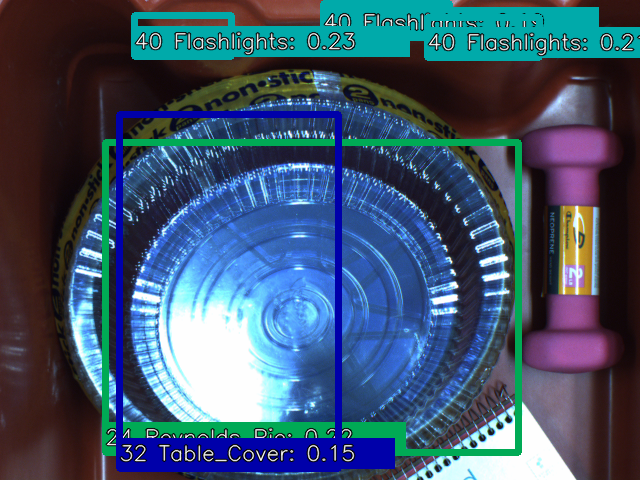

In [39]:
from IPython.display import Image,display_png
display_png(Image('./out/detection/2017-016-2.png')) 

BoundingBoxが表示されていなかったり，クラスが異なっていたり，うまく検出/識別できていないことが確認できます．
この結果は，学習が30epochのみであり，十分に学習が行えていないためです．

次に評価を実施します．検出されたバウンディングボックス1つに対して，その画像に存在するすべての教師信号のバウンディングボックスとIoUを比較して，最もIoUが高いものを探索します．見つかったボックスのクラスと検出されたボックスのクラスと2つのボックスのIoUを計算し，テキストファイルに書き出します．
次に，書き出したテキストファイルを読んでConfusion Matrixを計算します．IoUが閾値以上かつクラスが合っていれば検出成功，そうでなければ検出失敗とします．計算が終了すると，画像形式のConfusion Matrixと，次の3つの値を出力します．
- 識別率: 検出された物体のうち，クラスが正しかった割合
- 未検出率: 全ての物体のうち，検出できなかった割合
- 平均IoU: 全てのバウンディングボックスのIoUの平均

In [40]:
%pwd
!ls ./val/rgb/
!ls ./out/detection_txt/

2017-001-1.png	2017-026-1.png	2017-051-1.png	2017-076-1.png	2017-101-1.png
2017-001-2.png	2017-026-2.png	2017-051-2.png	2017-076-2.png	2017-101-2.png
2017-006-1.png	2017-031-1.png	2017-056-1.png	2017-081-1.png	2017-106-1.png
2017-006-2.png	2017-031-2.png	2017-056-2.png	2017-081-2.png	2017-106-2.png
2017-011-1.png	2017-036-1.png	2017-061-1.png	2017-086-1.png	2017-111-1.png
2017-011-2.png	2017-036-2.png	2017-061-2.png	2017-086-2.png	2017-111-2.png
2017-016-1.png	2017-041-1.png	2017-066-1.png	2017-091-1.png	2017-116-1.png
2017-016-2.png	2017-041-2.png	2017-066-2.png	2017-091-2.png	2017-116-2.png
2017-021-1.png	2017-046-1.png	2017-071-1.png	2017-096-1.png	2017-121-1.png
2017-021-2.png	2017-046-2.png	2017-071-2.png	2017-096-2.png	2017-121-2.png
2017-001-1res.txt  2017-031-1res.txt  2017-061-2res.txt  2017-096-1res.txt
2017-001-2res.txt  2017-031-2res.txt  2017-066-1res.txt  2017-096-2res.txt
2017-006-1res.txt  2017-036-1res.txt  2017-071-1res.txt  2017-101-1res.txt
2017-006-2res.txt  2017-0

./out/detection_txt/2017-106-2res.txt
Result
Matching Success
Matching Failed
(24, 94, 84, 528, 410)0.3281845715303759
No Match
(39, 71, 57, 262, 480)
(11, 229, 313, 400, 479)
(20, 260, 105, 461, 308)
(27, 446, 59, 621, 235)
(14, 475, 244, 614, 439)
(7, 359, 455, 640, 480)
File output
./out/detection_txt/2017-011-1res.txt
Result
Matching Success
Matching Failed
(40, 245, 242, 324, 285)0.013784461152882205
No Match
(20, 62, 138, 248, 352)
(14, 126, 289, 339, 466)
(10, 153, 411, 400, 480)
(4, 91, 0, 622, 479)
(19, 293, 0, 470, 148)
(39, 449, 0, 628, 334)
File output
./out/detection_txt/2017-011-2res.txt
Result
Matching Success
Matching Failed
(32, 317, 85, 633, 421)0.5617366946778711
(40, 224, 2, 347, 37)0.0
(40, 322, 3, 449, 37)0.2562195063040433
(40, 134, 16, 231, 57)0.9426773855295352
(40, 428, 17, 540, 57)0.33266849809957477
No Match
(29, 73, 162, 342, 275)
(11, 97, 264, 323, 403)
(4, 98, 414, 271, 480)
(15, 518, 116, 640, 290)
(39, 466, 295, 630, 480)
File output
./out/detection_txt

<ipython-input-41-c305c7f7d825>:288: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([str(i)+'%' for i in range(0, 101, 10)])


1: 0.0
2: 0.0
3: 0.0
4: 0.0
5: 0.0
6: 0.0
7: 0.0
8: 0.0
9: 0.0
10: 0.0
11: 0.0
12: 0.0
13: 0.0
14: 0.0
15: 0.0
16: 0.0
17: 0.0
18: 0.0
19: 0.0
20: 0.0
21: 0.0
22: 0.0
23: 0.0
24: 0.5
25: 0.0
26: 0.0
27: 0.0
28: 0.0
29: 0.0
30: 0.0
31: 0.0
32: 0.0
33: 0.0
34: 0.0
35: 0.0
36: 0.0
37: 0.0
38: 0.0
39: 0.0
40: 0.0


<Figure size 640x480 with 0 Axes>

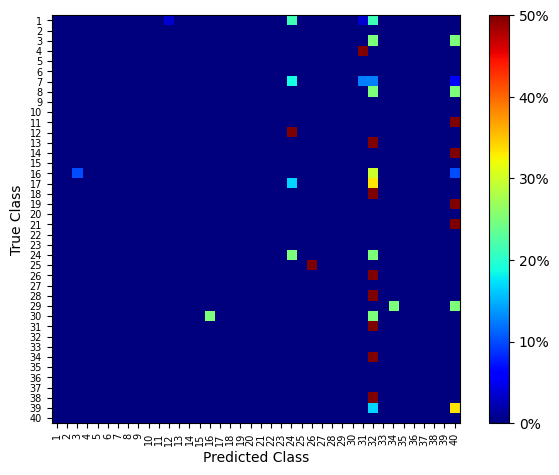

In [41]:
image_path = "./val/rgb/"
teach_path = "./val/boundingbox/"
result_path = "./out/detection_txt/"

# IoU matching results path
match_result_path = result_path + "matchingResults/"

# evaluation output(totalresult, confusion_matrix) path
eval_result_path = result_path + "eval/"

# wait time of cv2.waitKey (if 0 then no wait)
WAITTIME = 0

# if your detection results have a classlabel(e.g.: DVD, avery_binder...), set 1
LABEL_FLAG = 1

# if your detection results are normalized, set 1
NORMALIZED = 0

#IOU Threshold
# IOU_THRESH = 0.55
IOU_THRESH = 0.2

# if teach labels have category and color classification results, set 1
# normally need not change
CAT_PASS_FLAG = 0

# normally need not change
THRESH = 0.35
NCLASS = 40

COLOR_TABLE = common_params.arc_class_color
itemIDList = common_params.itemIDList

def convNormalizedCord(data, height, width):
    x = float(data[1]) * width
    y = float(data[2]) * height
    w = float(data[3]) * width
    h = float(data[4]) * height
    x1 = x - (w/2.)
    y1 = y - (h/2.)
    x2 = x + (w/2.)
    y2 = y + (h/2.)
    return(int(data[0]), int(x1), int(y1), int(x2), int(y2))

def convResCord(data, height, width, normalized):
    if normalized == 1:
        data = convNormalizedCord(data, height, width)
    if int(data[0]) == 0:
        classID = 41
    else:
        classID = int(data[0])
    return(classID, int(data[1]), int(data[2]), int(data[3]), int(data[4]))

def getIOU(boxA, boxB):
    # if the length of between boxAcenter and boxBcenter is too far, return 0
    center_boxA = np.array([(boxA[0] + boxA[2]) / 2.0, (boxA[1] + boxA[3]) / 2.0])
    center_boxB = np.array([(boxB[0] + boxB[2]) / 2.0, (boxB[1] + boxB[3]) / 2.0])
    if np.linalg.norm(center_boxA - center_boxB) >= 500:
        return 0

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_area = (xB - xA + 1) * (yB - yA + 1)
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = inter_area / float(boxA_area + boxB_area - inter_area)

    return iou

def readTxt(file_path, d_type, label_flag=0, cat_pass_flag=0):
    coordinate = []
    f = open(file_path, 'r')

    if f != None:
        for row in f:
            data = row.split()
            if(label_flag==1 and d_type == "result"):
                data = [data[0], data[2], data[3], data[4], data[5]]
            elif(d_type == "result"):
                data = [data[0], data[1], data[2], data[3], data[4]]
            elif(cat_pass_flag==1 and d_type == "teach"):
                data = [data[0], data[3], data[4], data[5], data[6]]
            elif(d_type == "teach" or d_type == "evaluate"):
                data = data
                # DO NOTHING
            else:
                print("[ERROR] Unexpected text data type:" + d_type)
                return 1
            coordinate.append(data)
        f.close()
        return coordinate
    else:
        print("[ERROR] Can't read:" + file_path)
        return 1

def drawBB(img, data):
    color = [ COLOR_TABLE[int(data[0])][2], COLOR_TABLE[int(data[0])][1], COLOR_TABLE[int(data[0])][0] ]
    height, width = img.shape[:2]
    x1 = data[1]
    y1 = data[2]
    x2 = data[3]
    y2 = data[4]
    cv.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
    cv.putText(img, itemIDList[int(data[0])], (x1, y1-2), cv.FONT_HERSHEY_TRIPLEX, 1, (255,255,255), 2)
    cv.putText(img, itemIDList[int(data[0])], (x1, y1), cv.FONT_HERSHEY_TRIPLEX, 1, (0,0,0), 1)
    return img

def matching(file_list):
    for file_path in file_list:
        print(file_path)
        file_name, ext = os.path.splitext(os.path.basename(file_path) )
        file_name = file_name.replace("res", "")

        result_data = readTxt(file_path, "result", label_flag=LABEL_FLAG)
        teach_data = readTxt(teach_path + file_name + ".txt", "teach", cat_pass_flag=CAT_PASS_FLAG)
        img = cv.imread(image_path + file_name + ".png")
        height, width = img.shape[:2]
        img_backup = img.copy()

        # Convert to Full(teach) coordinates
        for i in range(0, len(teach_data)):
            teach_data[i] = convNormalizedCord(teach_data[i], height, width)

        # Convert for result coordinates
        for i in range(0, len(result_data)):
            result_data[i] = convResCord(result_data[i], height, width, NORMALIZED)

        # init result lists
        hit = [False] * len(teach_data)
        success = [False] * len(result_data)
        max_IoU_list = [0] * len(result_data)
        true_category = [0] * len(result_data)

        # search box which have highest IoU value
        for j in range(0, len(result_data)):
            max_IoU = 0.0
            max_index = 0
            for i in range(0, len(teach_data)):
                iou = getIOU(teach_data[i][1:], result_data[j][1:])
                if(max_IoU < iou) and (iou <= 1.0):
                    max_IoU = iou
                    max_index = i
                if WAITTIME != 0:
                    img = img_backup.copy()
                    img = drawBB(img, teach_data[i])
                    img = drawBB(img, result_data[j])
                    cv.imshow("", img)
                    cv.waitKey(WAITTIME)

            # found
            max_IoU_list[j] = max_IoU
            img = img_backup.copy()
            if(max_IoU > THRESH):
                hit[max_index] = True
                success[j] = (teach_data[max_index][0] == result_data[j][0])
                true_category[j] = teach_data[max_index][0]
                if WAITTIME != 0:
                    img = drawBB(img, teach_data[max_index])
                    img = drawBB(img, result_data[j])
                    cv.putText(img, "Max IoU:" + str(max_IoU), (0, 25) , cv.FONT_HERSHEY_TRIPLEX, 1, (255,255,255), 2)
                    cv.putText(img, "Class Match:" + str(success[j]), (0, 50) , cv.FONT_HERSHEY_TRIPLEX, 1, (255,255,255), 2)
            else:
                if WAITTIME != 0:
                    img = drawBB(img, result_data[j])
                    cv.putText(img, "No Matching", (0, 25) , cv.FONT_HERSHEY_TRIPLEX, 1, (255,255,255), 2)
            if WAITTIME != 0:
                cv.imshow("", img)
                cv.waitKey(WAITTIME*5)

        print("Result")
        print("Matching Success")
        for i in range(0, len(result_data)):
            if(success[i] == True):
                print(str(result_data[i]))

        print("Matching Failed")
        for i in range(0, len(result_data)):
            if(success[i] == False):
                print(str(result_data[i]) + str(max_IoU_list[i]))

        print("No Match")
        for i in range(0, len(teach_data)):
            if(hit[i] == False):
                print(str(teach_data[i]))

        print("File output")
        f = open(result_path + "matchingResults/" + file_name + ".txt", 'w')
        for i in range(0, len(result_data)):
            write_data = str(result_data[i][0]) + " " + str(true_category[i]) + " " + str(max_IoU_list[i]) + '\n'
            f.writelines(write_data)
        # miss boxes
        for i in range(0, len(teach_data)):
            if(hit[i] == False):
                write_data = "0" + " " + str(teach_data[i][0]) + " 0.0" + '\n'
                f.writelines(write_data)
        f.close()

    if WAITTIME != 0:
        cv.destroyAllWindows()

def evaluate(file_list):
    conv_ID_table = [i for i in range(0, NCLASS+1)]

    total_boxes = 0             # number of all(detected + not detected) boxes
    total_true_boxes = 0        # number of true class boxes
    total_detected_boxes = 0    # number of detected boxes
    total_false_boxes = 0       # number of false class boxes
    total_undetected_boxes = 0  # number of not detected boxes
    total_IoU = 0.0

    confusion_mat = [[0 for i in range(NCLASS)] for j in range(NCLASS)]

    for filePath in file_list:
        boxes = 0
        true_boxes = 0
        detected_boxes = 0
        false_boxes = 0
        undetected_boxes = 0

        result_data = readTxt(filePath, "evaluate")

        for i in range(0, len(result_data)):
            boxes += 1
            if(result_data[i][0] != '0' and result_data[i][1] != '0'):
                #detected
                detected_boxes += 1
                total_IoU += float(result_data[i][2])
                confusion_mat[conv_ID_table[int(result_data[i][1])]-1][conv_ID_table[int(result_data[i][0])]-1] += 1
                if(float(result_data[i][2]) >= IOU_THRESH):
                    #IOU >= Threshold
                    if (result_data[i][0] == result_data[i][1]):
                        #true class
                        true_boxes += 1
                    else:
                        #false class
                        false_boxes += 1
                else:
                    #low IOU
                    false_boxes += 1
            else:
                #not detected
                undetected_boxes += 1

        if boxes != (detected_boxes + undetected_boxes):
            print("[Error] missmatch: boxes != detected_boxes + undetected_boxes")
            print(boxes, detected_boxes, undetected_boxes)
            sys.exit()
        if detected_boxes != (true_boxes + false_boxes):
            print("[Error] missmatch: detected_boxes != true_boxes + false_boxes")
            print(detected_boxes, true_boxes, false_boxes)
            sys.exit()

        total_boxes += boxes
        total_true_boxes += true_boxes
        total_detected_boxes += detected_boxes
        total_false_boxes += false_boxes
        total_undetected_boxes += undetected_boxes

    print("Total Result")
    print("Matching Rate: "+str(float(total_true_boxes) / float(total_detected_boxes)))
    print("Miss(No detection box) Rate: "+str(float(total_undetected_boxes) / float(total_boxes)))
    print("Mean IoU:"+ str(total_IoU / total_detected_boxes))

    #confusion_matrix normalization
    normalized_matrix = []
    for i in confusion_mat:
        a = 0
        temp_matrix = []
        a = sum(i,0)
        for j in i:
            if a == 0:
                temp_matrix.append(0.0)
            else:
                temp_matrix.append(float(j) / float(a))
        normalized_matrix.append(temp_matrix)

    #draw confusion_matrix
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    res = ax.imshow(np.array(normalized_matrix), cmap=plt.cm.jet, interpolation='nearest')
    cb = fig.colorbar(res)
    cb.ax.set_yticklabels([str(i)+'%' for i in range(0, 101, 10)])
    confusion_mat = np.array(confusion_mat)
    width, height = confusion_mat.shape
    item_list = [str(i) for i in range(1, NCLASS+1)]
    plt.xticks(range(width), item_list[:width],rotation=90)
    plt.yticks(range(height), item_list[:height])
    plt.tick_params(labelsize=7)
    plt.subplots_adjust(left=0.05, bottom=0.10, right=0.95, top=0.95)
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")

    for i in range(0, NCLASS):
        print(str(i+1) + ": " + str(normalized_matrix[i][i]))

    #file output
    f = open(eval_result_path + "/totalresult.txt", 'w')
    f.writelines("Total Result" + '\n')
    f.writelines("Matching Rate: "+str(float(total_true_boxes) / float(total_detected_boxes)) + '\n')
    f.writelines("Miss(No detection box) Rate: "+str(float(total_undetected_boxes) / float(total_boxes)) + '\n')
    f.writelines("Mean IoU:"+ str(total_IoU / total_detected_boxes) + '\n')
    for i in range(0, NCLASS):
        f.writelines(str(i+1) + ": " + str(normalized_matrix[i][i]) + '\n')
    f.close()

    plt.savefig(eval_result_path + "/confusion_matrix.pdf", format="pdf")
    plt.savefig(eval_result_path + "/confusion_matrix.png", format="png")


def main():
    # mkdir for Matching results
    if not os.path.exists(result_path + "/matchingResults"): os.mkdir(result_path + "/matchingResults")
    if not os.path.exists(result_path + "/eval"): os.mkdir(result_path + "/eval")

    # IoU matching
    file_list = glob(result_path + "*.txt")
    if len(file_list) == 0:
        print("[Error] Detection results file list is empty. Check this dir:" + result_path)
        file_list.sort()
    else:
        matching(file_list)

    # evaluate and output
    file_list = glob(match_result_path + "/*.txt")
    if len(file_list) == 0:
        print("[Error] Evaluation file list is empty. Check this dir:" + match_result_path)
    else:
        file_list.sort()
        evaluate(file_list)

if __name__ == '__main__':
    main()

Total Result以降が学習済みモデルの評価結果を表しています．

Matching Rate: 0.125 \\
Miss(No detection box) Rate: 0.7018633540372671 \\
Mean IoU:0.7933524104872776 \\

30epochのみの学習のため，良い結果とは言えません．本来は150epochほど学習を進める必要があります．

ここまでで，SSDによる物体検出の流れを確認しました．

## 学習済みモデルによる評価
学習済みモデルによる評価を行います．

In [42]:
IN_DIR = "./val/rgb"                 # 評価データのパス
OUT_DIR = "./out_pretrained"        # 結果保存先
MODEL_PATH = "./SSD_pretrained.pth"  # モデルのパス

# クラスラベル
print(len(labels))

def test_out2():
    # ディレクトリの作成
    if SAVE_DATA:
        make_dir_list = [
            OUT_DIR,
            OUT_DIR + '/detection',                     # 検出結果のb-box画像
            OUT_DIR + '/detection_txt'                  # 検出結果のb-boxテキスト
        ]
        for dirname in make_dir_list:
            if not(os.path.exists(dirname)): os.mkdir(dirname)
    # 学習モデル読み込み
    ssd_pretrained = SSDNet()
    ssd_pretrained.load_state_dict(torch.load(MODEL_PATH))
    if use_cuda:
      ssd_pretrained.cuda()

    # default boxのサイズリスト計算
    step = int(math.floor((common_params.max_ratio - common_params.min_ratio) / (len(common_params.mbox_source_layers) - 2)))
    min_sizes = []
    max_sizes = []
    for ratio in range(common_params.min_ratio, common_params.max_ratio + 1, step):
            min_sizes.append(common_params.insize * ratio / 100.)
            max_sizes.append(common_params.insize * (ratio + step) / 100.)
    min_sizes = [common_params.insize * 10 / 100.] + min_sizes
    max_sizes = [common_params.insize * 20 / 100.] + max_sizes

    # 入力画像の読み込み
    color_img = glob(os.path.join(IN_DIR, '*' + '.png'))
    color_img.sort()

    # 読み込んだリストを順次検出
    ssd_pretrained.eval()
    for lf in range(len(color_img)):
        img = cv.imread(color_img[lf])
        filename, ext = os.path.splitext(os.path.basename(color_img[lf]))

        if img is None:
            print("[Error] 画像が読み込めません: " + str(color_img[lf]))
            sys.exit(1)
        detection(img, ssd_pretrained, filename, min_sizes, max_sizes)

if __name__ == '__main__':
    test_out2()

41
Total Time :  0.1945362091064453
----- Detection Done -----
Total Time :  0.19947218894958496
----- Detection Done -----
Total Time :  0.20456719398498535
----- Detection Done -----
Total Time :  0.1978447437286377
----- Detection Done -----
Total Time :  0.22099804878234863
----- Detection Done -----
Total Time :  0.1985635757446289
----- Detection Done -----
Total Time :  0.1944279670715332
----- Detection Done -----
Total Time :  0.19159770011901855
----- Detection Done -----
Total Time :  0.19600653648376465
----- Detection Done -----
Total Time :  0.19863271713256836
----- Detection Done -----
Total Time :  0.18756437301635742
----- Detection Done -----
Total Time :  0.1977221965789795
----- Detection Done -----
Total Time :  0.19779205322265625
----- Detection Done -----
Total Time :  0.21336603164672852
----- Detection Done -----
Total Time :  0.20402026176452637
----- Detection Done -----
Total Time :  0.20289039611816406
----- Detection Done -----
Total Time :  0.1951634883

./out_pretrained/detection_txt/2017-106-2res.txt
Result
Matching Success
(20, 254, 105, 458, 301)
(27, 440, 66, 618, 243)
Matching Failed
(4, 75, 57, 260, 425)0.8430866745283019
(9, 76, 53, 260, 377)0.7229025661002094
(9, 454, 60, 623, 241)0.9091132702004674
(19, 255, 109, 453, 301)0.8878192208284922
(20, 464, 246, 622, 438)0.8686147812389494
(22, 68, 53, 243, 440)0.797847809377402
(40, 109, 423, 187, 480)0.21840242669362994
No Match
(11, 229, 313, 400, 479)
(7, 359, 455, 640, 480)
File output
./out_pretrained/detection_txt/2017-011-1res.txt
Result
Matching Success
Matching Failed
(13, 382, 0, 638, 332)0.6974552309142319
(32, 438, 4, 638, 338)0.8754683711703769
(34, 78, 19, 316, 332)0.4071130320123068
(37, 85, 0, 293, 153)0.12198186386976947
(37, 131, 308, 363, 473)0.7632467442982154
No Match
(10, 153, 411, 400, 480)
(4, 91, 0, 622, 479)
(19, 293, 0, 470, 148)
File output
./out_pretrained/detection_txt/2017-011-2res.txt
Result
Matching Success
Matching Failed
(2, 314, 102, 545, 393)0.8

<ipython-input-41-c305c7f7d825>:288: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([str(i)+'%' for i in range(0, 101, 10)])


1: 0.07894736842105263
2: 0.25
3: 0.1111111111111111
4: 0.2727272727272727
5: 0.3333333333333333
6: 0.14285714285714285
7: 0.16666666666666666
8: 0.05263157894736842
9: 0.0
10: 0.25
11: 0.0
12: 0.0
13: 1.0
14: 0.0
15: 0.125
16: 0.25
17: 0.1
18: 0.25
19: 0.16666666666666666
20: 0.3125
21: 0.0
22: 0.0
23: 0.07692307692307693
24: 0.25
25: 0.6
26: 0.125
27: 0.25
28: 0.09090909090909091
29: 0.0
30: 0.0
31: 0.09090909090909091
32: 0.14285714285714285
33: 0.0
34: 0.4
35: 0.25
36: 0.0
37: 0.0
38: 0.0
39: 0.0
40: 0.2857142857142857


<Figure size 640x480 with 0 Axes>

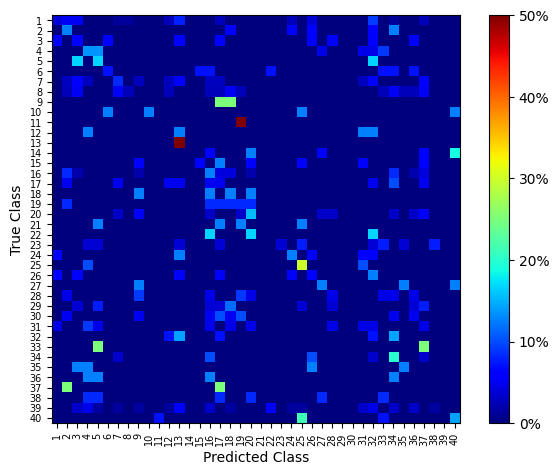

In [43]:
result_path = "./out_pretrained/detection_txt/"

# IoU matching results path
match_result_path = result_path + "/matchingResults/"

# evaluation output(totalresult, confusion_matrix) path
eval_result_path = result_path + "/eval/"

def main():
    # mkdir for Matching results
    if not os.path.exists(result_path + "/matchingResults"): os.mkdir(result_path + "/matchingResults")
    if not os.path.exists(result_path + "/eval"): os.mkdir(result_path + "/eval")

    # IoU matching
    file_list = glob(result_path + "*.txt")
    if len(file_list) == 0:
        print("[Error] Detection results file list is empty. Check this dir:" + result_path)
        file_list.sort()
    else:
        matching(file_list)

    # evaluate and output
    file_list = glob(match_result_path + "*.txt")
    if len(file_list) == 0:
        print("[Error] Evaluation file list is empty. Check this dir:" + match_result_path)
    else:
        file_list.sort()
        evaluate(file_list)

if __name__ == '__main__':
    main()

Matching Rate: 0.13978494623655913

Miss(No detection box) Rate: 0.14285714285714285

Mean IoU: 0.8332557799526265

になりました．

これで，学習から評価まで一通り行うことができました．

# 課題
1. エポック数を変えて実験し，検出精度の変化を確認しましょう．

In [44]:
#ここにコードを書く

# 参考文献
 - [1] Wei Liu, Dragomir Anguelov, Dumitru Erhan , Christian Szegedy, Scott E. Reed, Cheng-Yang Fu and Alexander C. Berg, "SSD: Single Shot MultiBox Detector". In 2016 European Conference on Computer Vision, pp. 21-37, 2016.